# User Classification using Embeddings

**Date:** 4th December 2024

**Dataset:** German Web Tracking

In [1]:
import sys
import os

sys.path.append(os.path.abspath("../"))

In [2]:
import pickle
import numpy as np
import pandas as pd

from cybergpt.models.classification import DimensionalityReducer, ClassificationEvaluation
from cybergpt.models.utils import feature_df_to_numpy

## Data

In order to generate the required processed data, please run the following:

**Embeddings**

```shell
python -m cybergpt.models.embed.websites \
    --data_csv path/to/raw/data.csv \
    --output_dir data/embeddings \
    --models openai openai-large minilm e5 tfidf \
    --sample_size 200
```

Note that sequences of domain visits are first mapped to strings which look like this:

`"Monday 14:15, Visits: google.com (10s) -> youtube.com (89s) -> google.com (32s) -> amazon.de (123s)"`

**Features**

```shell
python -m cybergpt.models.features \
    --data_csv path/to/raw/data.csv \
    --output_dir data/features
```

In [3]:
SEQUENCES_PICKLE = "../data/embeddings/preprocessed_dataset.pkl"
EMBEDDINGS_PICKLES = {
    "openai": "../data/embeddings/embeddings_openai.pkl",
    "openai-large": "../data/embeddings/embeddings_openai-large.pkl",
    "tfidf": "../data/embeddings/embeddings_tfidf.pkl",
    "e5": "../data/embeddings/embeddings_e5.pkl",
    "minilm": "../data/embeddings/embeddings_minilm.pkl",
}
FEATURES_PICKLE = "../data/features/features.pkl"

In [4]:
data = pickle.load(open(SEQUENCES_PICKLE, "rb"))
sequences = data["string_sequences"]
labels = data["labels"]

embeddings = {
    e: pickle.load(open(p, "rb")) for e, p in EMBEDDINGS_PICKLES.items()
}

In [5]:
feature_data = pickle.load(open(FEATURES_PICKLE, "rb"))
all_labels = feature_data["labels"]
features = feature_data["features"]
np_features = feature_df_to_numpy(features)

In [6]:
# Align features with embeddings subset
users = pd.Series(labels).drop_duplicates().to_list()
feature_arrays = [np.array([f for f, l in zip(np_features, all_labels) if l == u]) for u in users]
np_features = np.concatenate(feature_arrays)

In [7]:
print("Shapes:")
{"features": np_features.shape} | {k: v.shape for k, v in embeddings.items()}

Shapes:


{'features': (7806, 51),
 'openai': (7806, 1536),
 'openai-large': (7806, 3072),
 'tfidf': (7806, 11387),
 'e5': (7806, 384),
 'minilm': (7806, 384)}

In [8]:
print(f"Number of sequences: {len(labels)}")

Number of sequences: 7806


Remove users with fewer than `MIN_SUPPORT` sequences.

In [9]:
MIN_SUPPORT = 20

In [10]:
few_labels = pd.Series(labels).value_counts()
few_labels = list(few_labels[few_labels < MIN_SUPPORT].index)

In [11]:
np_features = np.array([f for f, l in zip(np_features, labels) if l not in few_labels])
embeddings = {
    k: np.array([e for e, l in zip(embs, labels) if l not in few_labels])
    for k, embs in embeddings.items()
}
labels = [l for l in labels if l not in few_labels]

In [12]:
print(f"Remaining number of users: {pd.Series(labels).nunique()}")
print(f"Remaining number of sequences: {len(labels)}")

Remaining number of users: 121
Remaining number of sequences: 7126


## Results

- Baseline uses hand-crafted features based on the sequences. See `cybergpt.models.features` for details.
- Embeddings are projected down via PCA so they have the same number of dimensions as the number of features in the baseline.
- Multinomial logistic regression and random forest classifiers are applied to the (projected) feature matrices in order to predict the user_id.

In [13]:
results = {}

In [14]:
y = np.array(labels)
train_indices = None
cv_splits = None

print("Features Baseline")
print("-" * len("Features Baseline"))

X = np_features
evaluator = ClassificationEvaluation(X, y, train_indices, cv_splits)
evaluator.prepare_data()
results["baseline"] = evaluator.evaluate_models()

train_indices = evaluator.train_indices
cv_splits = evaluator.cv_splits

print("")

Features Baseline
-----------------

Evaluating logistic...


/Users/marcos/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/marcos/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/marcos/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



Classification Report for logistic:
accuracy: 0.34642356241234223
macro avg: {'precision': 0.30078801835907654, 'recall': 0.284580111476388, 'f1-score': 0.2731764692112418, 'support': 1426.0}
weighted avg: {'precision': 0.332460280125103, 'recall': 0.34642356241234223, 'f1-score': 0.31990827531784954, 'support': 1426.0}

Cross-validation scores: 0.324 (+/- 0.013)

Evaluating rf...

Classification Report for rf:
accuracy: 0.33590462833099577
macro avg: {'precision': 0.2607866961498465, 'recall': 0.2653105187158217, 'f1-score': 0.25122452420754965, 'support': 1426.0}
weighted avg: {'precision': 0.3043771553905144, 'recall': 0.33590462833099577, 'f1-score': 0.307302770055735, 'support': 1426.0}

Cross-validation scores: 0.324 (+/- 0.011)



/Users/marcos/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/marcos/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/marcos/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [15]:
PROJ_DIM = np_features.shape[1]
PROJ_DIM

51

Model: openai
-------------


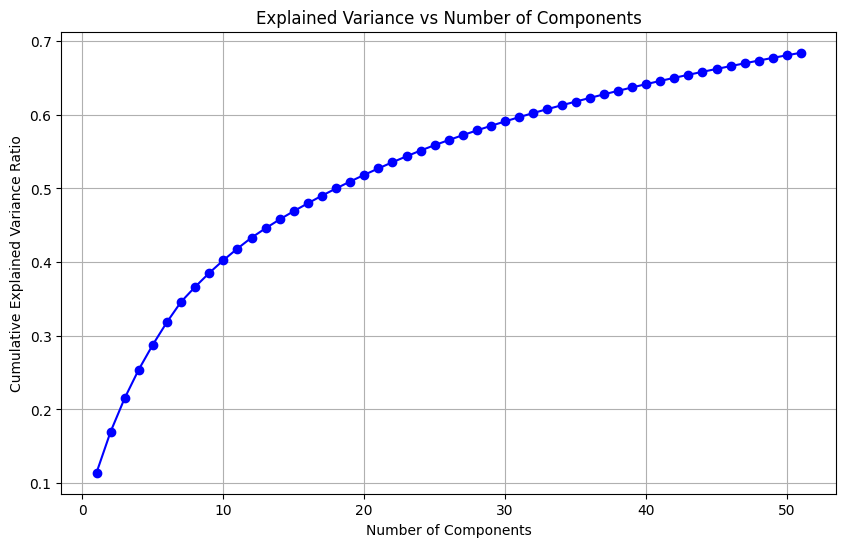

Original shape: (7126, 1536)
Reduced shape: (7126, 51)
Total explained variance ratio: 0.684

Evaluating logistic...

Classification Report for logistic:
accuracy: 0.7194950911640954
macro avg: {'precision': 0.6790626474697897, 'recall': 0.6568556994905602, 'f1-score': 0.6582325701322269, 'support': 1426.0}
weighted avg: {'precision': 0.7281777889229611, 'recall': 0.7194950911640954, 'f1-score': 0.7164105885324127, 'support': 1426.0}

Cross-validation scores: 0.724 (+/- 0.023)

Evaluating rf...


/Users/marcos/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/marcos/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/marcos/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



Classification Report for rf:
accuracy: 0.6830294530154277
macro avg: {'precision': 0.6647726175492108, 'recall': 0.5928033747638958, 'f1-score': 0.5950630587410303, 'support': 1426.0}
weighted avg: {'precision': 0.6886049250593139, 'recall': 0.6830294530154277, 'f1-score': 0.6608130530573935, 'support': 1426.0}

Cross-validation scores: 0.678 (+/- 0.023)

Model: openai-large
-------------------


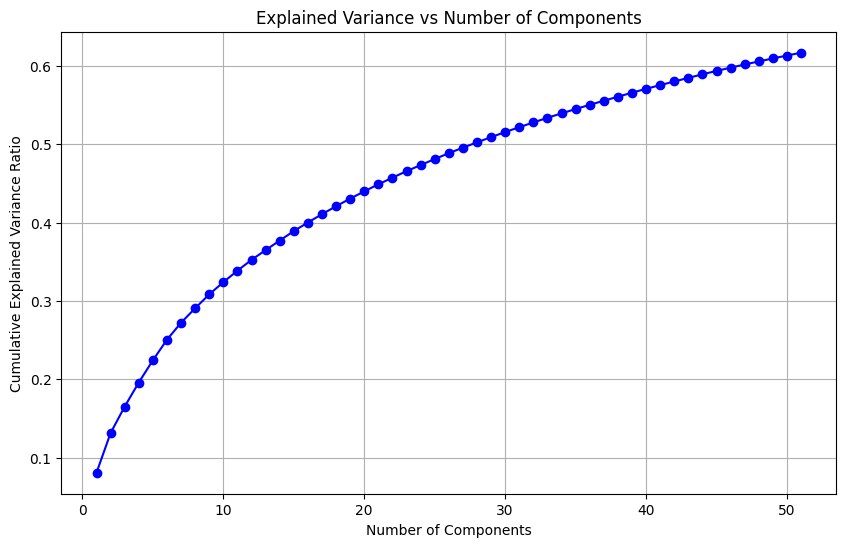

Original shape: (7126, 3072)
Reduced shape: (7126, 51)
Total explained variance ratio: 0.617

Evaluating logistic...


/Users/marcos/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/marcos/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/marcos/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



Classification Report for logistic:
accuracy: 0.7321178120617111
macro avg: {'precision': 0.691094436379814, 'recall': 0.6615219013079502, 'f1-score': 0.6625765489072808, 'support': 1426.0}
weighted avg: {'precision': 0.7416010902431855, 'recall': 0.7321178120617111, 'f1-score': 0.7277992172053979, 'support': 1426.0}

Cross-validation scores: 0.728 (+/- 0.020)

Evaluating rf...


/Users/marcos/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/marcos/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/marcos/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



Classification Report for rf:
accuracy: 0.6619915848527349
macro avg: {'precision': 0.6290564366823662, 'recall': 0.5651952676978403, 'f1-score': 0.567264417250626, 'support': 1426.0}
weighted avg: {'precision': 0.6665921664531519, 'recall': 0.6619915848527349, 'f1-score': 0.6410158338489661, 'support': 1426.0}

Cross-validation scores: 0.673 (+/- 0.021)

Model: tfidf
------------


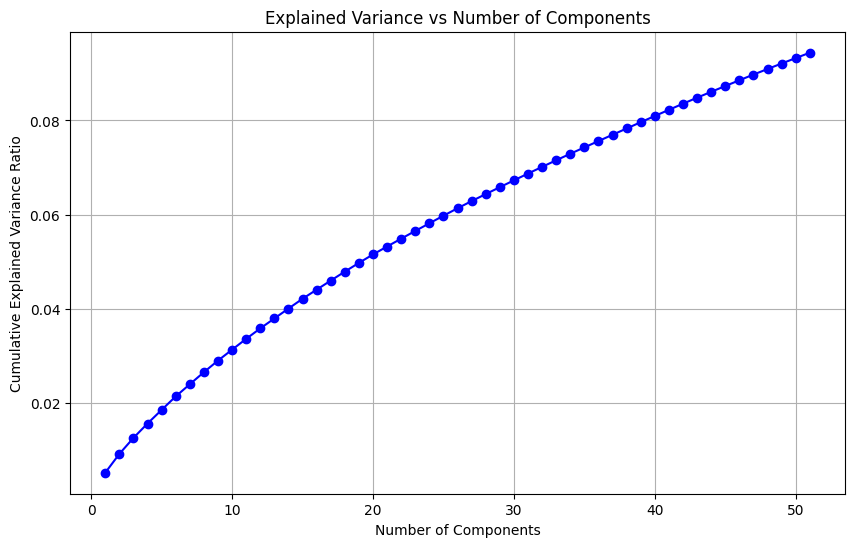

Original shape: (7126, 11387)
Reduced shape: (7126, 51)
Total explained variance ratio: 0.094

Evaluating logistic...


/Users/marcos/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/marcos/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/marcos/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



Classification Report for logistic:
accuracy: 0.2482468443197756
macro avg: {'precision': 0.23856286545609492, 'recall': 0.18015166075419672, 'f1-score': 0.16469803188873525, 'support': 1426.0}
weighted avg: {'precision': 0.25557242470131475, 'recall': 0.2482468443197756, 'f1-score': 0.19195345099230876, 'support': 1426.0}

Cross-validation scores: 0.234 (+/- 0.009)

Evaluating rf...


/Users/marcos/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/marcos/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/marcos/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



Classification Report for rf:
accuracy: 0.3962131837307153
macro avg: {'precision': 0.3562568868259524, 'recall': 0.32458450713370846, 'f1-score': 0.31080267134231293, 'support': 1426.0}
weighted avg: {'precision': 0.3686112492744356, 'recall': 0.3962131837307153, 'f1-score': 0.35640339373446184, 'support': 1426.0}

Cross-validation scores: 0.402 (+/- 0.010)

Model: e5
---------


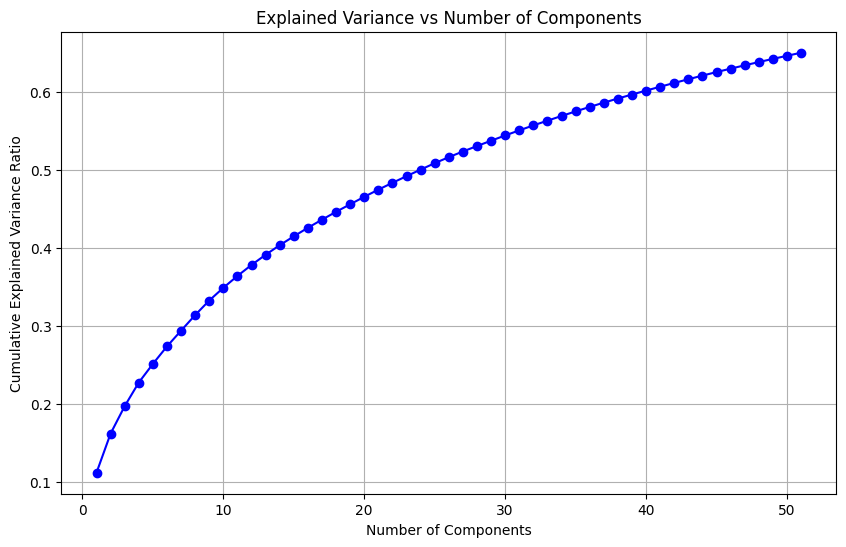

Original shape: (7126, 384)
Reduced shape: (7126, 51)
Total explained variance ratio: 0.650

Evaluating logistic...

Classification Report for logistic:
accuracy: 0.6276297335203366
macro avg: {'precision': 0.5597852792446375, 'recall': 0.5451445885626487, 'f1-score': 0.5423273306359483, 'support': 1426.0}
weighted avg: {'precision': 0.6268188212008814, 'recall': 0.6276297335203366, 'f1-score': 0.6199011423037363, 'support': 1426.0}

Cross-validation scores: 0.632 (+/- 0.023)

Evaluating rf...


/Users/marcos/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/marcos/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/marcos/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



Classification Report for rf:
accuracy: 0.5806451612903226
macro avg: {'precision': 0.5336584036315872, 'recall': 0.46706991239801005, 'f1-score': 0.46238533709664054, 'support': 1426.0}
weighted avg: {'precision': 0.5741003199722978, 'recall': 0.5806451612903226, 'f1-score': 0.5483120556248395, 'support': 1426.0}

Cross-validation scores: 0.565 (+/- 0.019)

Model: minilm
-------------


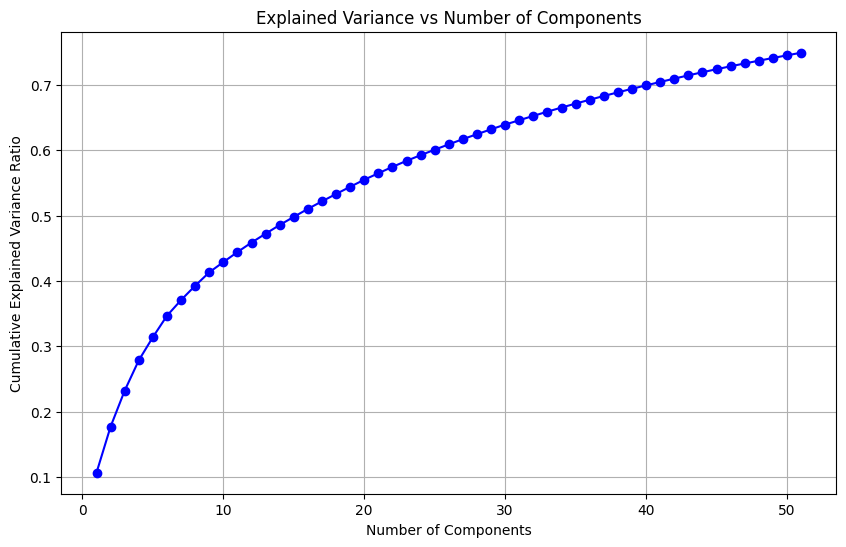

Original shape: (7126, 384)
Reduced shape: (7126, 51)
Total explained variance ratio: 0.749

Evaluating logistic...

Classification Report for logistic:
accuracy: 0.6493688639551192
macro avg: {'precision': 0.601128663263415, 'recall': 0.5821520011025177, 'f1-score': 0.579148154588498, 'support': 1426.0}
weighted avg: {'precision': 0.6610029050522441, 'recall': 0.6493688639551192, 'f1-score': 0.6455405136230414, 'support': 1426.0}

Cross-validation scores: 0.646 (+/- 0.024)

Evaluating rf...

Classification Report for rf:
accuracy: 0.5925666199158486
macro avg: {'precision': 0.5537046190977937, 'recall': 0.490588727123165, 'f1-score': 0.4884927985792949, 'support': 1426.0}
weighted avg: {'precision': 0.583554590890972, 'recall': 0.5925666199158486, 'f1-score': 0.5638010782053675, 'support': 1426.0}

Cross-validation scores: 0.603 (+/- 0.013)



/Users/marcos/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/marcos/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/marcos/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [16]:
y = np.array(labels)
for model, embs in embeddings.items():
    print(f"Model: {model}")
    print("-" * len(f"Model: {model}"))
    
    X = embs
    X_train = X[train_indices, :]
    reducer = DimensionalityReducer()
    reducer.fit(X_train, PROJ_DIM)
    _ = reducer.analyze_explained_variance()
    
    X_reduced = reducer.reduce_dimensions(X)

    evaluator = ClassificationEvaluation(X_reduced, y, train_indices, cv_splits)
    evaluator.prepare_data()
    results[model] = evaluator.evaluate_models()

    train_indices = evaluator.train_indices
    cv_splits = evaluator.cv_splits

    print("")

In [17]:
output = {
    "results": results,
    "labels": labels,
}
pickle.dump(output, open("../data/embeddings/results.pkl", "wb"))

### Results Summary

In [18]:
def summary(model):
    return pd.DataFrame({k: {f"mean_{m}": v for m, v in results[k][model]["classification_report"]["macro avg"].items()} | {
        "accuracy": results[k][model]["classification_report"]["accuracy"],
        "mean_cv_score": np.mean(results[k][model]["cv_scores"])
    } for k in results}).T.sort_values("mean_f1-score", ascending=False).round(2).drop("mean_support", axis=1)

In [19]:
summary("logistic")

,mean_precision,mean_recall,mean_f1-score,accuracy,mean_cv_score
openai-large,0.69,0.66,0.66,0.73,0.73
openai,0.68,0.66,0.66,0.72,0.72
minilm,0.60,0.58,0.58,0.65,0.65
e5,0.56,0.55,0.54,0.63,0.63
baseline,0.30,0.28,0.27,0.35,0.32
tfidf,0.24,0.18,0.16,0.25,0.23


In [20]:
summary("rf")

,mean_precision,mean_recall,mean_f1-score,accuracy,mean_cv_score
openai,0.66,0.59,0.60,0.68,0.68
openai-large,0.63,0.57,0.57,0.66,0.67
minilm,0.55,0.49,0.49,0.59,0.60
e5,0.53,0.47,0.46,0.58,0.57
tfidf,0.36,0.32,0.31,0.40,0.40
baseline,0.26,0.27,0.25,0.34,0.32
